## MATING STRATEGIES

### 01 load model

In [2]:
import sys
sys.path.append("../../deeplab/")
sys.path.append("../../")
import os

import pandas as pd
import numpy as np
from utils import load_model, load_image, plot_result
from postprocess.post_process_utils import post_process_panoptic
from analyser.multi_fluorescent_image_feature import FluorescentImage, FluorescentClassification
from analyser.cell_image import CellImage
%load_ext autoreload
%autoreload 2

In [3]:
model = load_model("../../../data/checkpoint/", "../../deeplab/configs/config_wl.yaml")

2023-02-26 13:39:45.699626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 13:39:49.024896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


../../../data/checkpoint/
restoring or initializing model...
restored model from ../../../data/checkpoint/ckpt-100000.
restored from checkpoint: ../../../data/checkpoint/ckpt-100000


### 02 load image and prediction mask

In [4]:
image = load_image("../../../data/image/20220707_yGL0360xyGL0105_06_snapshot_R3D.tif")

In [5]:
output = model.predict(image[:,:,0])

In [6]:
mask = post_process_panoptic(output["panoptic_pred"][0].numpy(), area_threshold=1250, clean_border_region=True)

### 03 counting

In [7]:
fimageobj = CellImage(image, mask)

In [8]:
plt.hist(fimageobj.mask.instance_properties.area)

NameError: name 'plt' is not defined

In [9]:
data = fimageobj.get_fluorescent_intensity()
cluster = FluorescentClassification(data)
data_pred, clustering = cluster.predition_data_type(n_components=4, init_params='kmeans')

,label,ch1,ch2,bg1,bg2,ch1_norm,ch2_norm,channel_prediction
1010,1010,959.0,203.0,1725.784462,266.338888,0.921171,0.951374,0
1011,1011,1666.6,271.0,1725.784462,266.338888,0.995318,1.003107,0
1012,1012,1581.5,367.0,1725.784462,266.338888,0.988286,1.057405,0
1013,1013,2857.2,317.0,1725.784462,266.338888,1.067641,1.031180,0
1014,1014,6354.6,214.0,1725.784462,266.338888,1.174885,0.960823,1
...,...,...,...,...,...,...,...,...
5018,5018,1842.0,262.0,1725.784462,266.338888,1.008744,0.997059,0
5019,5019,6131.6,269.0,1725.784462,266.338888,1.170093,1.001780,1
5020,5020,1330.0,291.0,1725.784462,266.338888,0.965049,1.015856,0
5021,5021,1174.0,254.0,1725.784462,266.338888,0.948310,0.991506,0


### 04 save result

In [146]:
showdata = cluster.data.copy()
showdata[['centroid_0','centroid_1','semantic']] = fimageobj.mask.instance_properties[['centroid_0','centroid_1','semantic']]

In [147]:
LABELMAP = {0: [0], 1: [1], 2: [2, 3]}
w = fimageobj.mask.get_cells(showdata.loc[showdata.channel_prediction.isin(LABELMAP[0])].index)
r = fimageobj.mask.get_cells(showdata.loc[showdata.channel_prediction.isin(LABELMAP[1])].index)
g = fimageobj.mask.get_cells(showdata.loc[showdata.channel_prediction.isin(LABELMAP[2])].index)

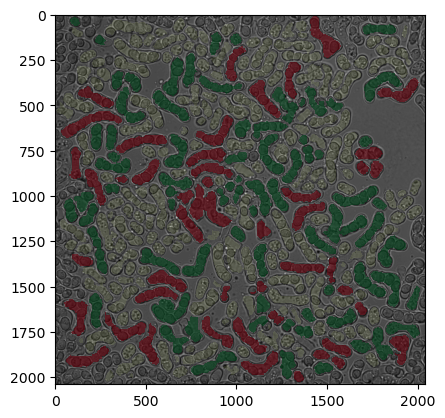

In [149]:
plt.imshow(image[:,:,0], 'gray')
plt.imshow(np.ma.masked_where(r<1, r>0), vmin=0.5, cmap='Greens', alpha=0.6)
plt.imshow(np.ma.masked_where(g<1, g>0), vmin=0.5, cmap='Reds', alpha=0.6)
plt.imshow(np.ma.masked_where(w<1, w>0), cmap='Wistia', alpha=0.1)

In [65]:

s = np.ma.masked_where(show[:,:,1]<1, show[:,:,1])
red = image[:,:,1]*(im > 0)
# green = image[:,:,1]*(im > 0)

In [68]:
show = np.zeros((image.shape[0],image.shape[1],3))

In [92]:
show[:,:,0] = image[:,:,0]
show[:,:,1] = red

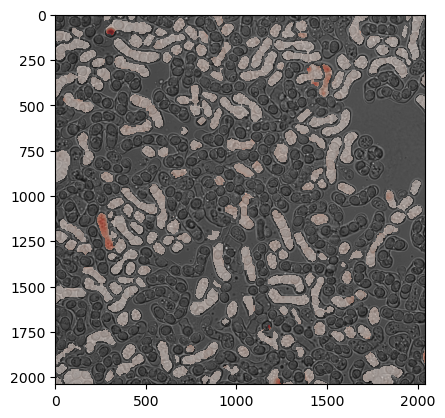

In [93]:
plt.imshow(show[:,:,0], 'gray')
s = np.ma.masked_where(show[:,:,1]<1, show[:,:,1])
plt.imshow(s, cmap='Reds', alpha=0.5)

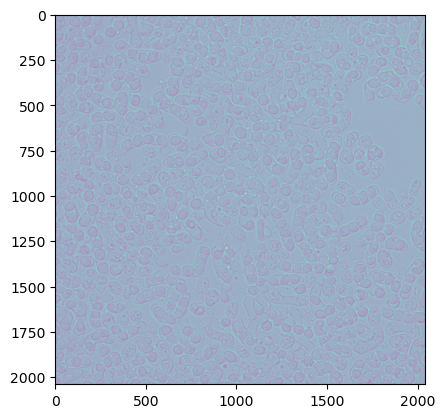

In [75]:
plt.imshow(show[:,:,0])


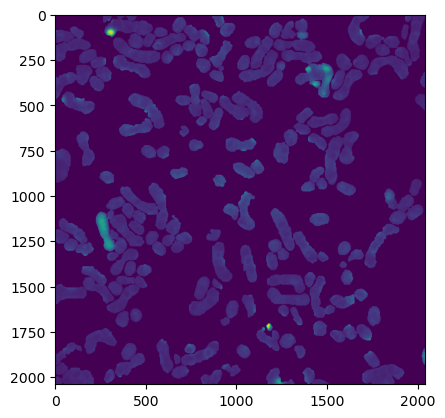

In [74]:
plt.imshow(show[:,:,1])

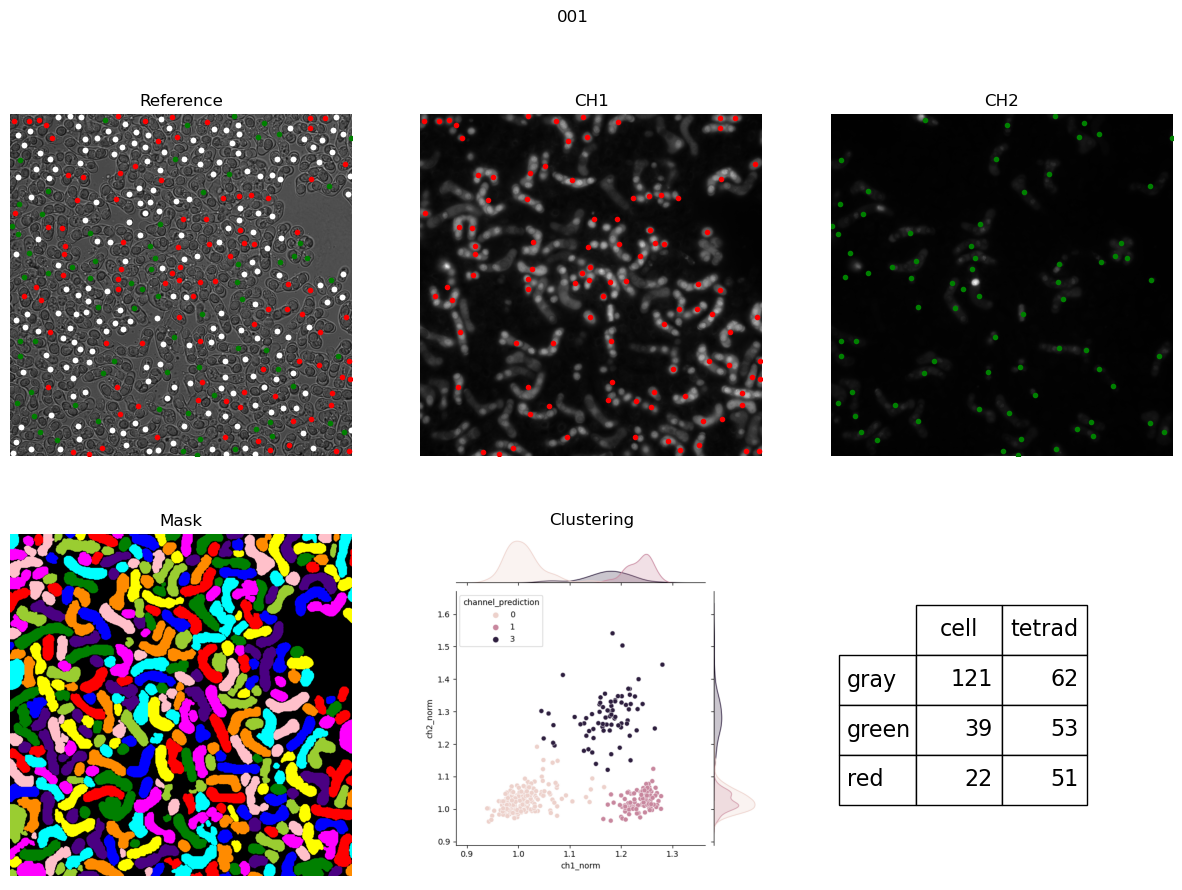

In [53]:
fig, tabel = plot_result(image, showdata, mask=mask, basename=basename)

In [31]:
save_path = "./test/"
basename = "001"
all_tabel = pd.DataFrame(columns=['cell_gray','tetrad_gray','cell_green','terad_green','cell_red','tetrad_red'],)

In [41]:
all_tabel.loc[basename] =tabel.values.flatten()
all_tabel.to_csv(os.path.join(save_path, basename+".csv"))
fig.savefig(os.path.join(save_path, basename+'.png'))

## run with command line

In [42]:
import sys
sys.path.append("../../../deepyeast/")

In [43]:
from utils import batch_processing

In [44]:
batch_processing("../../../../data/Sj_MATECHOICE/" ,"../../../model_dir/deepyeast_001/","../../configs/config_wl.yaml","./test/")

FileNotFoundError: [Errno 2] No such file or directory: '../../configs/config_wl.yaml'

In [1]:
!python run_batch_processing.py --root_dir="../../../../data/Sj_MATECHOICE/" --model_dir="../../../model_dir/deepyeast_001/" --config_file="../../configs/config_wl.yaml" --save_path="./test/"

2023-01-03 01:35:18.788848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 01:35:20.569125: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-03 01:35:25.101346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /dcsrsoft/spack/arolle/v1.0/spack/opt/spack/linux-rhel8-zen/gcc-8.4.1/gcc-10.4.0-7fjdev7tbifqfonsjwlqmr6qcnza2ezu/lib64:/dcsrsoft/spack/arolle/v1.0/spack/opt/spack/linux-rhel8-zen/gcc-8.4.1/gcc-10.4.0-7fjdev7tbif